# Modelo con Transfer Learning - VERSION VGG19

In [1]:
import os 
import tensorflow as tf
import keras  
import numpy as np
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 1. Procesar imagenes


Partimos de un dataset con 9 categorias diferentes: ['Drought_Disaster', 'Earthquake_Disaster', 'LandSlide_Disaster', 'Non_Damage_Buildings_Street', 'Non_Damage_Sea', 'Non_Damage_Wildlife_Forest', 'Urban_Fire_Disaster', 'Water_Disaster', 'Wild_Fire_Disaster']

Cada carpeta cuenta con un nuemro diferente de imagenes, entre 200 y 4000 imagenes por clase.

Para la version de 'transfer learning', vamos a utilizar una version reducida de la base de datos debido al gran tiempo necesario para el entrenamiento , en el modelo de anterios usamos unas 600 imagenes por categoria y ahora se utilizaran unas 200. El modelo base será el 'VGG19'

In [71]:
# Accedemos a la base de datos
train_dir='reduced_data'              #Guarda la ruto donde se encuentra la bases de datos
classes=os.listdir(data_dir)          #Obtiene el  nombre de las carpetas 
print(classes)

# Se determinan parámetros del conjunto con el que se trabajara
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

#Se crea la base de datos desde el directorio con keras
train_full = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,    
)

['Drought_Disaster', 'Earthquake_Disaster', 'LandSlide_Disaster', 'Non_Damage_Buildings_Street', 'Non_Damage_Sea', 'Non_Damage_Wildlife_Forest', 'Urban_Fire_Disaster', 'Water_Disaster', 'Wild_Fire_Disaster']
Found 2675 files belonging to 9 classes.


## 2. División del conjunto

In [72]:
# Obtenemos la cantidad de batches y dividimos en 80/10/10
num_all_batches = len(list(train_full))
num_train_batches = int(num_all_batches * 0.8)
num_valid_test_batches = int(num_all_batches - num_train_batches)

# Imprimimos el número de lotes para el conjunto de datos de entrenamiento, validación y prueba
print(f'Number of  Train  batches : {num_train_batches}')
print(f'Number of Validation batches : {num_valid_test_batches//2}')
print(f'Number of Test batches : {num_valid_test_batches//2}')

Number of  Train  batches : 67
Number of Validation batches : 8
Number of Test batches : 8


In [73]:
# Dividimos con las funciones skit y take de keras
train_ds = train_full.take(num_train_batches)

remain = train_full.skip(num_train_batches)

valid_ds = remain.take(num_valid_test_batches//2)
test_ds = remain.skip(num_valid_test_batches//2)


In [74]:
# Visualizamos el tamaño y formato del conjunto
for x, y in test_ds.take(1):
    print("Image batch shape:", x.shape)
    print("Label batch shape:", y.shape)
    print("Example label:", y[0].numpy())

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)
Example label: [0. 0. 0. 0. 0. 0. 1. 0. 0.]


## 3. Modelo base VGG19

Cargamos el modelo base con los pesos predeterminados al entrenar con el conjunto de imagenes de ImageNet y lo adaptamos para nuestro problema de 9 clases e imagenes de 224x224 en color RGB.

In [43]:
import keras

# Cargar el modelo preentrenado VGG19 con pesos de imagenet
pretrained_model = keras.applications.VGG19(
    weights='imagenet', classes=9, input_shape=(224, 224, 3), include_top=False
)

In [44]:
# Visualizamos estrcutura modelo
pretrained_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Para nuestro modelo solo se entrenará la última capa del modelo VGG19, el resto se bloqueará con los valores predeterminados

In [61]:
# Congela todas las capas, salvo las del último modulo.
pretrained_model.trainable = False               # Congela todo el modelo
set_trainable = False                            # Inicializa un marcador

for layer in pretrained_model.layers :           # Bucle que lee todas las capas del modelo
    if layer.name == 'block5_conv1' :            # Encuentra la primera capa del último bloque
        set_trainable = True                     # Cambia el marcador
    if set_trainable :                           
        layer.trainable = True                   # Desbloquea las capas siguientes


In [62]:
# Genera listado de la configuración de cada capa
for layer in pretrained_model.layers :
    print(layer.name,'"Trainable" set as:',layer.trainable)

input_4 "Trainable" set as: False
block1_conv1 "Trainable" set as: False
block1_conv2 "Trainable" set as: False
block1_pool "Trainable" set as: False
block2_conv1 "Trainable" set as: False
block2_conv2 "Trainable" set as: False
block2_pool "Trainable" set as: False
block3_conv1 "Trainable" set as: False
block3_conv2 "Trainable" set as: False
block3_conv3 "Trainable" set as: False
block3_conv4 "Trainable" set as: False
block3_pool "Trainable" set as: False
block4_conv1 "Trainable" set as: False
block4_conv2 "Trainable" set as: False
block4_conv3 "Trainable" set as: False
block4_conv4 "Trainable" set as: False
block4_pool "Trainable" set as: False
block5_conv1 "Trainable" set as: True
block5_conv2 "Trainable" set as: True
block5_conv3 "Trainable" set as: True
block5_conv4 "Trainable" set as: True
block5_pool "Trainable" set as: True


## 4. Arquitectura del modelo

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [58]:
# Visualizamos el modelo base
model_base = Sequential()
model_base.add(pretrained_model)    
model_base.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________


In [21]:
# Añadimos capas personalizadas a nuestro modelo base
model = Sequential()
model.add(pretrained_model)                             # Añadimos nuestro modelo pre-entrenado
model.add(keras.layers.Dropout(0.5))                    # Usamos Dropout para evitar over-fitting
model.add(keras.layers.GlobalAveragePooling2D())        # Aplicamos GlobalAveragePooling2D
model.add(keras.layers.Flatten())                       # Convertimos la salida en un arraay de 1D
model.add(keras.layers.Dense(256, activation='relu'))   # Añadimos capa densa de 256 neuron con ReLU
model.add(keras.layers.Dropout(0.5))                    # Usamos Dropout para evitar over-fitting
model.add(keras.layers.Dense(9, activation='softmax'))  # Capa de salida con tantas neuronas como clases con 'softmax'

In [23]:
# Visualizamos las entradas y salida de cada capa
for layer in model.layers:
    print(f"Nombre de la capa: {layer.name}")
    print(f"  Tamaño de entrada: {layer.input_shape}")
    print(f"  Tamaño de salida: {layer.output_shape}")
    print("-" * 20)

Nombre de la capa: vgg19
  Tamaño de entrada: (None, 224, 224, 3)
  Tamaño de salida: (None, 7, 7, 512)
--------------------
Nombre de la capa: dropout
  Tamaño de entrada: (None, 7, 7, 512)
  Tamaño de salida: (None, 7, 7, 512)
--------------------
Nombre de la capa: global_average_pooling2d
  Tamaño de entrada: (None, 7, 7, 512)
  Tamaño de salida: (None, 512)
--------------------
Nombre de la capa: flatten
  Tamaño de entrada: (None, 512)
  Tamaño de salida: (None, 512)
--------------------
Nombre de la capa: dense
  Tamaño de entrada: (None, 512)
  Tamaño de salida: (None, 256)
--------------------
Nombre de la capa: dropout_1
  Tamaño de entrada: (None, 256)
  Tamaño de salida: (None, 256)
--------------------
Nombre de la capa: dense_1
  Tamaño de entrada: (None, 256)
  Tamaño de salida: (None, 9)
--------------------


In [18]:
# Visualizamos el modelo final
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [20]:
# Usamos CheckPoint Call-Back, para guardar los mejores parámetros como un archivo .keras
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel_vgg19.keras', save_best_only=True) 

# Early Stoping Call-Backc para parar el proceso de entrenamiento despueés de 'patience' épocas si no mejora
earlystop_cb = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

# ReduceLROnPlateau Call-Back para reducir la tasa de aprendizaje según el parámetro 'monitor' 
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

In [21]:
# Añadimos optimizador
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

## 5. Entrenamiento

In [22]:
# Entrenamos el modelo con la función .fit 
history = model.fit(
    train_ds, 
    epochs=25,                                         # Número de épocas
    validation_data=valid_ds,                          # Grupo de validación
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr] # Lista de reguladores
)

Epoch 1/25
67/67 [==============================] - 176s 3s/step - loss: 2.0481 - accuracy: 0.3321 - val_loss: 1.3638 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 2/25
67/67 [==============================] - 177s 3s/step - loss: 1.3119 - accuracy: 0.5410 - val_loss: 0.9765 - val_accuracy: 0.6992 - lr: 1.0000e-04
Epoch 3/25
67/67 [==============================] - 176s 3s/step - loss: 0.9921 - accuracy: 0.6744 - val_loss: 0.6897 - val_accuracy: 0.7695 - lr: 1.0000e-04
Epoch 4/25
67/67 [==============================] - 177s 3s/step - loss: 0.7470 - accuracy: 0.7486 - val_loss: 0.5000 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 5/25
67/67 [==============================] - 175s 3s/step - loss: 0.6200 - accuracy: 0.7976 - val_loss: 0.4250 - val_accuracy: 0.8672 - lr: 1.0000e-04
Epoch 6/25
67/67 [==============================] - 174s 3s/step - loss: 0.4514 - accuracy: 0.8456 - val_loss: 0.3019 - val_accuracy: 0.9023 - lr: 1.0000e-04
Epoch 7/25
67/67 [==============================] - 

## 5. Evaluación 

Como medida de seguridad guardamos los datos del entrenamiento en un archivo CSV, por si es necesario acceder a ellos de nuevo.

In [23]:
import pandas as pd

# Convertir el resultado del entrenamiento a DataFrame
result_df = pd.DataFrame(history.history)

# Guardar el historial de entrenamiento (result_df) en un archivo CSV
result_df.to_csv('training_results_vgg19.csv', index=False)


In [25]:
# # Callbacks devuelve los pesos del modelo base en "MyModel_vgg19.keras"
# # Para cargarlos se utiliza keras.models.load_model
# best_model = keras.models.load_model('MyModel_vgg19.keras')

In [75]:
# Evaluar el modelo en el grupo de test con model.evaluate()
loss, accuracy = model.evaluate(test_ds)
print(f'Loss : {loss}')
print(f'Accuracy : {accuracy*100}%')

9/9 [==============================] - 20s 2s/step - loss: 0.3921 - accuracy: 0.8836
Loss : 0.392115980386734
Accuracy : 88.36363554000854%


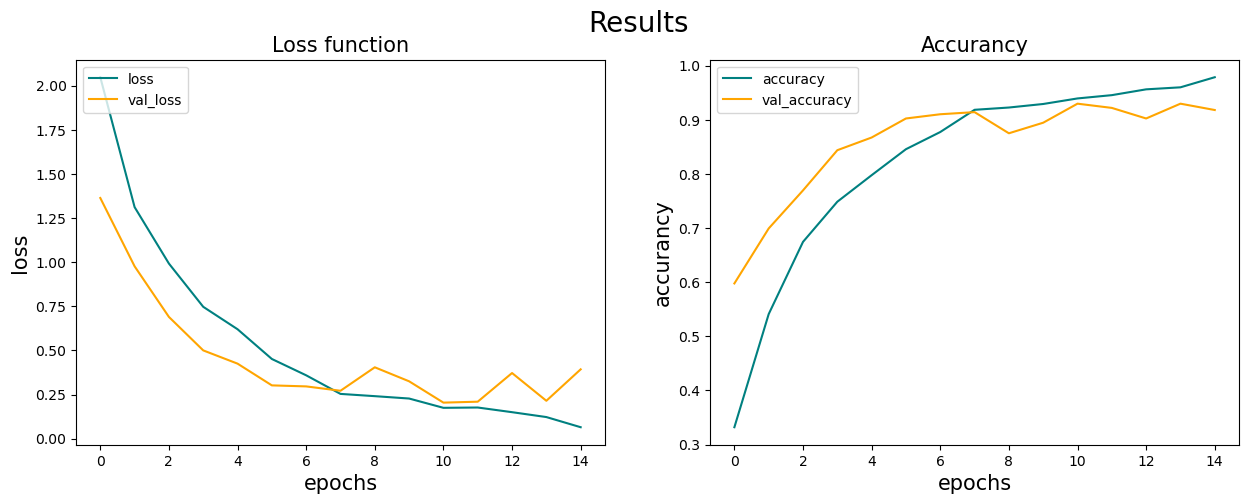

In [29]:
# Visualizar el proceso de entrenamiento
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,5))
fig.suptitle('Results', fontsize=20)

plt.subplot(121)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss function', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(loc="upper left")

plt.subplot(122)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accurancy', fontsize=15)
plt.ylabel('accurancy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(loc="upper left")

plt.show()
plt.close()

In [33]:
import numpy as np
import tensorflow as tf

# Calcular las predicciones sobre el conjunto de validación
y_true = []
y_pred = []

for images, labels in valid_ds:
    preds = model.predict(images)                     # Realiza la predicción
    y_pred.append(np.argmax(preds, axis=1))           # Agregar la clase predicha
    y_true.append(np.argmax(labels.numpy(), axis=1))  # Agregar la etiqueta verdadera

# Aplanar las listas de matrices en matrices 1D
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

1/1 [==============================] - 2s 2s/step


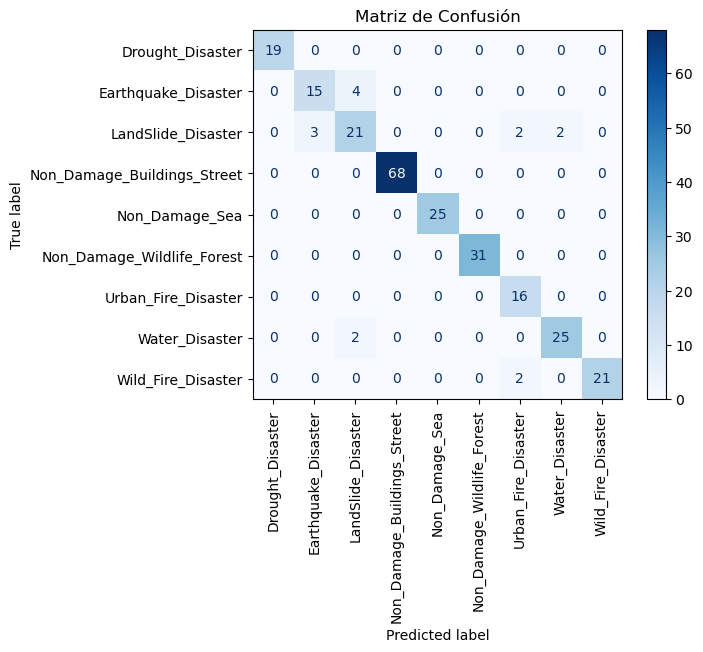

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Elaborar las matrices de confusión 
classes=os.listdir('reduce_data')   #Obtiene el  nombre de las carpetas 

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrar con etiquetas de clase
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()
plt.close()

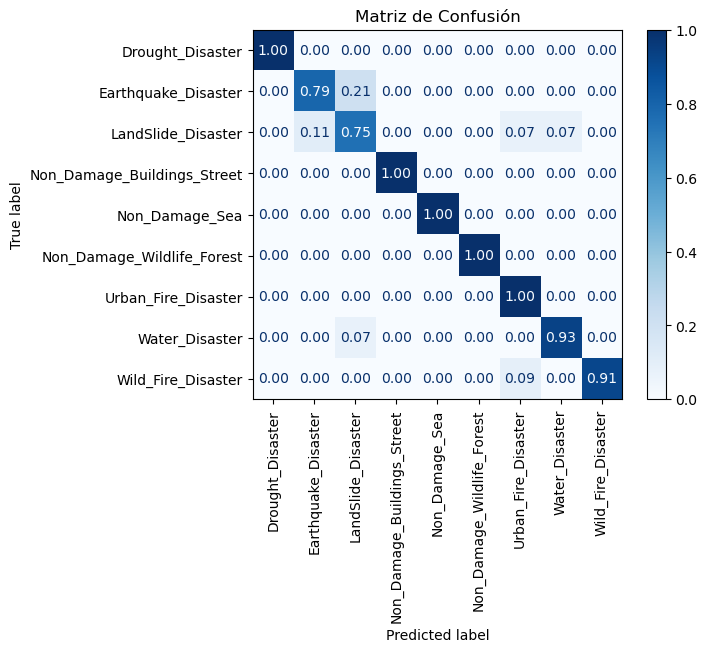

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Calcular la matriz de confusión normalizada (por filas)
cm = confusion_matrix(y_true, y_pred, normalize='true')  

# Mostrar con etiquetas de clase
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation='vertical',cmap='Blues', values_format='.2f')  # Mostrar valores con decimales
plt.title('Matriz de Confusión')
plt.show()
plt.close()

## 6. Test

Se procede a analizar con profundidad el rendmiento en el grupo de pruba (imagenes que el modelo no ha visto).

In [43]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report

# Se obtiene las predicciones y las etiquetas correctas:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.append(np.argmax(preds, axis=1))          # Convertir las precdicciones en indices de clase
    y_true.append(np.argmax(labels, axis=1))         # Convertir la etiquetas en formato one-hot

# Convertir a array de 1D
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Imprimir el informe con el nombre de las clases
class_names = train_full.class_names

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Precision (macro): 0.8633
Recall (macro): 0.8554
Accuracy: 0.8836

Classification Report:
                             precision    recall  f1-score   support

           Drought_Disaster       1.00      0.95      0.98        21
        Earthquake_Disaster       0.65      0.73      0.69        15
         LandSlide_Disaster       0.71      0.65      0.68        31
Non_Damage_Buildings_Street       0.99      0.99      0.99        75
             Non_Damage_Sea       0.96      0.96      0.96        26
 Non_Damage_Wildlife_Forest       1.00      1.00      1.00        27
        Urban_Fire_Disaster       0.87      0.59      0.70        22
             Water_Disaster       0.72      0.93      0.81        28
         Wild_Fire_Disaster       0.87      0.90      0.89        30

                   accuracy                           0.88       275
                  macro avg       0.86      0.86      0.85       275
               weighted avg       0.89      0.88      0.88       275



## 7. Guardar el modelo

Se guarda el modelo final con la función load.model en el directorio.

In [ ]:
model.save(os.path.join('models','imageclassifier10_vgg19.h5'))

## 8. Cargar el modelo

In [68]:
from tensorflow.keras.models import load_model

In [78]:
model = load_model(os.path.join('models', 'imageclassifier10_vgg19.h5'))